In [1]:
# # This mounts your Google Drive to the Colab VM.
# from google.colab import drive
# drive.mount('/content/drive')
#
# # TODO: Enter the foldername in your Drive where you have saved the unzipped
# # assignment folder, e.g. 'cs231n/assignments/assignment2/'
# FOLDERNAME = None
# assert FOLDERNAME is not None, "[!] Enter the foldername."
#
# # Now that we've mounted your Drive, this ensures that
# # the Python interpreter of the Colab VM can load
# # python files from within it.
# import sys
# sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))
#
# # This downloads the CIFAR-10 dataset to your Drive
# # if it doesn't already exist.
# %cd /content/drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
# !bash get_datasets.sh
# %cd /content/drive/My\ Drive/$FOLDERNAME

# Multi-Layer Fully Connected Network
In this exercise, you will implement a fully connected network with an arbitrary number of hidden layers.

Read through the `FullyConnectedNet` class in the file `cs231n/classifiers/fc_net.py`.

Implement the network initialization, forward pass, and backward pass. Throughout this assignment, you will be implementing layers in `cs231n/layers.py`. You can re-use your implementations for `affine_forward`, `affine_backward`, `relu_forward`, `relu_backward`, and `softmax_loss` from Assignment 1. For right now, don't worry about implementing dropout or batch/layer normalization yet, as you will add those features later.

通读文件“cs231n/classifiers/fc_net.py”中的“FullyConnectedNet”类。

实现网络初始化、前向传递和后向传递。在整个任务中，您将在`cs231n/layers.py `中实现层。您可以重复使用赋值1中的`affine_forward `、`affine_backward`、`relu_forward`、` relu_backward`和`softmax_liss `的实现。现在，不要担心实现dropout或批处理/层规范化，因为稍后您将添加这些功能。

In [2]:
# Setup cell.
import time
import numpy as np
import matplotlib.pyplot as plt
from cs231n.classifiers.fc_net import *
from cs231n.data_utils import get_CIFAR10_data
from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.solver import Solver

%matplotlib inline
plt.rcParams["figure.figsize"] = (10.0, 8.0)  # Set default size of plots.
plt.rcParams["image.interpolation"] = "nearest"
plt.rcParams["image.cmap"] = "gray"

%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """Returns relative error."""
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [3]:
# Load the (preprocessed) CIFAR-10 data.
data = get_CIFAR10_data()
for k, v in list(data.items()):
    print(f"{k}: {v.shape}")

X_train: (49000, 3, 32, 32)
y_train: (49000,)
X_val: (1000, 3, 32, 32)
y_val: (1000,)
X_test: (1000, 3, 32, 32)
y_test: (1000,)


## Initial Loss and Gradient Check

As a sanity check, run the following to check the initial loss and to gradient check the network both with and without regularization. This is a good way to see if the initial losses seem reasonable.

For gradient checking, you should expect to see errors around 1e-7 or less.

In [4]:
np.random.seed(231)
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for reg in [0, 3.14]:
    print("Running check with reg = ", reg)
    model = FullyConnectedNet(
        [H1, H2],
        input_dim=D,
        num_classes=C,
        reg=reg,
        weight_scale=5e-2,
        dtype=np.float64
    )

    loss, grads = model.loss(X, y)
    print("Initial loss: ", loss)

    # Most of the errors should be on the order of e-7 or smaller.
    # NOTE: It is fine however to see an error for W2 on the order of e-5
    # for the check when reg = 0.0
    for name in sorted(grads):
        print(name)
        print(grads["W2"].shape)
        f = lambda _: model.loss(X, y)[0]
        grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
        print(f"{name} relative error: {rel_error(grad_num, grads[name])}")

Running check with reg =  0
Initial loss:  2.300479089768492
W1
(20, 30)
W1 relative error: 1.0252674471656573e-07
W2
(20, 30)
W2 relative error: 2.2120479295080622e-05
W3
(20, 30)
W3 relative error: 4.5623278736665505e-07
b1
(20, 30)
b1 relative error: 4.6600944653202505e-09
b2
(20, 30)
b2 relative error: 2.085654276112763e-09
b3
(20, 30)
b3 relative error: 1.689724888469736e-10
Running check with reg =  3.14
Initial loss:  7.052114776533016
W1
(20, 30)
W1 relative error: 6.862884860440611e-09
W2
(20, 30)
W2 relative error: 3.522821562176466e-08
W3
(20, 30)
W3 relative error: 2.6171457283983532e-08
b1
(20, 30)
b1 relative error: 1.4752427965311745e-08
b2
(20, 30)
b2 relative error: 1.7223751746766738e-09
b3
(20, 30)
b3 relative error: 2.378772438198909e-10


As another sanity check, make sure your network can overfit on a small dataset of 50 images. First, we will try a three-layer network with 100 units in each hidden layer. In the following cell, tweak the **learning rate** and **weight initialization scale** to overfit and achieve 100% training accuracy within 20 epochs.
作为另一个健全性检查，确保你的网络可以在50张图像的小数据集上过拟合。首先，我们将尝试一个三层网络，每个隐藏层有100个单元。在下面的单元格中，调整**学习率**和**权重初始化比例**，使其过拟合，并在20个迭代周期内达到100%的训练精度。

(Iteration 1 / 40) loss: 118.014768
(Epoch 0 / 20) train acc: 0.160000; val_acc: 0.108000
(Epoch 1 / 20) train acc: 0.120000; val_acc: 0.131000
(Epoch 2 / 20) train acc: 0.340000; val_acc: 0.104000
(Epoch 3 / 20) train acc: 0.540000; val_acc: 0.114000
(Epoch 4 / 20) train acc: 0.760000; val_acc: 0.115000
(Epoch 5 / 20) train acc: 0.840000; val_acc: 0.121000
(Iteration 11 / 40) loss: 4.123914
(Epoch 6 / 20) train acc: 0.800000; val_acc: 0.127000
(Epoch 7 / 20) train acc: 0.960000; val_acc: 0.116000
(Epoch 8 / 20) train acc: 0.980000; val_acc: 0.123000
(Epoch 9 / 20) train acc: 1.000000; val_acc: 0.125000
(Epoch 10 / 20) train acc: 1.000000; val_acc: 0.125000
(Iteration 21 / 40) loss: 0.001097
(Epoch 11 / 20) train acc: 1.000000; val_acc: 0.125000
(Epoch 12 / 20) train acc: 1.000000; val_acc: 0.125000
(Epoch 13 / 20) train acc: 1.000000; val_acc: 0.125000
(Epoch 14 / 20) train acc: 1.000000; val_acc: 0.127000
(Epoch 15 / 20) train acc: 1.000000; val_acc: 0.127000
(Iteration 31 / 40) loss

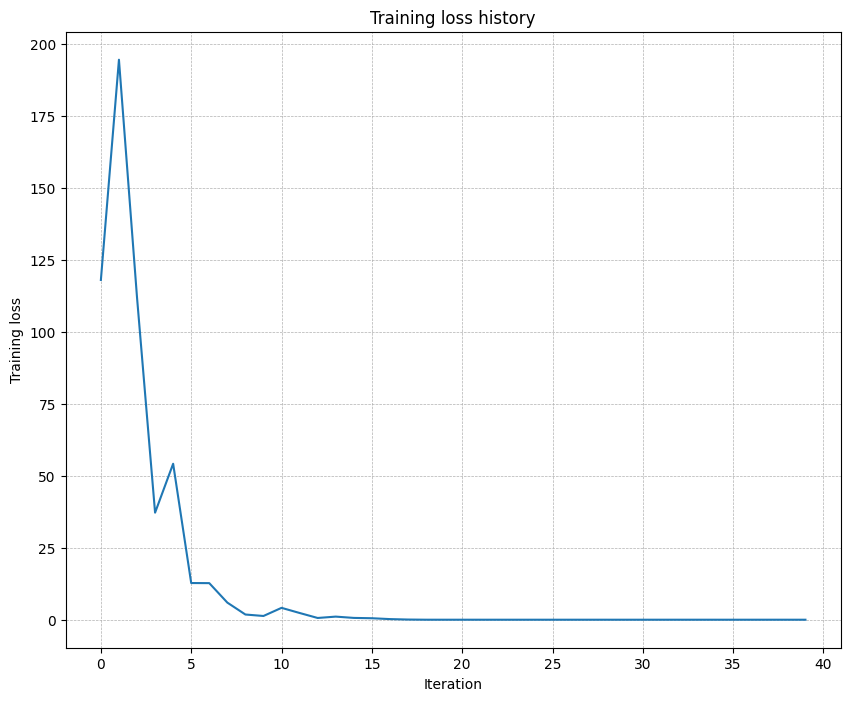

In [5]:
# TODO: Use a five-layer Net to overfit 50 training examples by
# tweaking just the learning rate and initialization scale.

num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

learning_rate = 1e-3  # Experiment with this!
weight_scale = 1e-1 # Experiment with this!
model = FullyConnectedNet(
    [100, 100, 100, 100],
    weight_scale=weight_scale,
    dtype=np.float64,
    input_dim=3 * 32 * 32
)
solver = Solver(
    model,
    small_data,
    print_every=10,
    num_epochs=20,
    batch_size=25,
    update_rule='sgd',
    optim_config={'learning_rate': learning_rate},
)
solver.train()

plt.plot(solver.loss_history)
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.grid(linestyle='--', linewidth=0.5)
plt.show()

## Inline Question 1:
Did you notice anything about the comparative difficulty of training the three-layer network vs. training the five-layer network? In particular, based on your experience, which network seemed more sensitive to the initialization scale? Why do you think that is the case?
你注意到训练三层网络和训练五层网络的相对难度了吗？特别是，根据你的经验，哪个网络似乎对初始化规模更敏感？你认为为什么会这样？
## Answer:
[FILL THIS IN]
训练五层网络更敏感，初始设置过大会导致梯度爆炸，初始设置过小会导致梯度消失。
训练五层网络比三层网络更敏感，尤其是在权重初始化规模的选择上。因为随着网络层数的增加，信号（包括前向传播的激活值和反向传播的梯度）通过每一层时可能会变得越来越大（导致梯度爆炸）或越来越小（导致梯度消失）。如果初始化的权重过大，经过多层之后，激活值可能会在每层中逐步放大，导致梯度爆炸；如果初始化的权重过小，激活值则会逐步缩小，导致梯度消失。这使得更深的网络对权重初始化的敏感性显著增加。相比之下，三层网络的信号传递路径较短，因此不太容易出现梯度消失或爆炸的问题。

这种现象在深层网络中尤为明显，因此更深的网络通常需要采用特定的权重初始化策略（如 Xavier 初始化或 He 初始化）来确保梯度能够合理传递。

# Update rules
So far we have used vanilla stochastic gradient descent (SGD) as our update rule. More sophisticated update rules can make it easier to train deep networks. We will implement a few of the most commonly used update rules and compare them to vanilla SGD.

## SGD+Momentum
Stochastic gradient descent with momentum is a widely used update rule that tends to make deep networks converge faster than vanilla stochastic gradient descent. See the Momentum Update section at http://cs231n.github.io/neural-networks-3/#sgd for more information.

Open the file `cs231n/optim.py` and read the documentation at the top of the file to make sure you understand the API. Implement the SGD+momentum update rule in the function `sgd_momentum` and run the following to check your implementation. You should see errors less than e-8.

In [6]:
from cs231n.optim import sgd_momentum

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
v = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {"learning_rate": 1e-3, "velocity": v}
next_w, _ = sgd_momentum(w, dw, config=config)
print(next_w)
expected_next_w = np.asarray([
  [ 0.1406,      0.20738947,  0.27417895,  0.34096842,  0.40775789],
  [ 0.47454737,  0.54133684,  0.60812632,  0.67491579,  0.74170526],
  [ 0.80849474,  0.87528421,  0.94207368,  1.00886316,  1.07565263],
  [ 1.14244211,  1.20923158,  1.27602105,  1.34281053,  1.4096    ]])
expected_velocity = np.asarray([
  [ 0.5406,      0.55475789,  0.56891579, 0.58307368,  0.59723158],
  [ 0.61138947,  0.62554737,  0.63970526,  0.65386316,  0.66802105],
  [ 0.68217895,  0.69633684,  0.71049474,  0.72465263,  0.73881053],
  [ 0.75296842,  0.76712632,  0.78128421,  0.79544211,  0.8096    ]])

# Should see relative errors around e-8 or less
print("next_w error: ", rel_error(next_w, expected_next_w))
print("velocity error: ", rel_error(expected_velocity, config["velocity"]))

[[0.1406     0.20738947 0.27417895 0.34096842 0.40775789]
 [0.47454737 0.54133684 0.60812632 0.67491579 0.74170526]
 [0.80849474 0.87528421 0.94207368 1.00886316 1.07565263]
 [1.14244211 1.20923158 1.27602105 1.34281053 1.4096    ]]
next_w error:  8.882347033505819e-09
velocity error:  4.269287743278663e-09


Once you have done so, run the following to train a six-layer network with both SGD and SGD+momentum. You should see the SGD+momentum update rule converge faster.

Running with  sgd
(Iteration 1 / 200) loss: 2.541697
(Epoch 0 / 5) train acc: 0.091000; val_acc: 0.105000
(Iteration 11 / 200) loss: 2.312049
(Iteration 21 / 200) loss: 2.157290
(Iteration 31 / 200) loss: 2.111794
(Epoch 1 / 5) train acc: 0.259000; val_acc: 0.227000
(Iteration 41 / 200) loss: 2.201454
(Iteration 51 / 200) loss: 2.030267
(Iteration 61 / 200) loss: 2.053895
(Iteration 71 / 200) loss: 2.051929
(Epoch 2 / 5) train acc: 0.306000; val_acc: 0.269000
(Iteration 81 / 200) loss: 2.019372
(Iteration 91 / 200) loss: 2.075696
(Iteration 101 / 200) loss: 2.042845
(Iteration 111 / 200) loss: 1.895288
(Epoch 3 / 5) train acc: 0.304000; val_acc: 0.281000
(Iteration 121 / 200) loss: 2.010662
(Iteration 131 / 200) loss: 1.806540
(Iteration 141 / 200) loss: 1.875015
(Iteration 151 / 200) loss: 1.738390
(Epoch 4 / 5) train acc: 0.362000; val_acc: 0.296000
(Iteration 161 / 200) loss: 1.761519
(Iteration 171 / 200) loss: 1.855714
(Iteration 181 / 200) loss: 1.871284
(Iteration 191 / 200) los

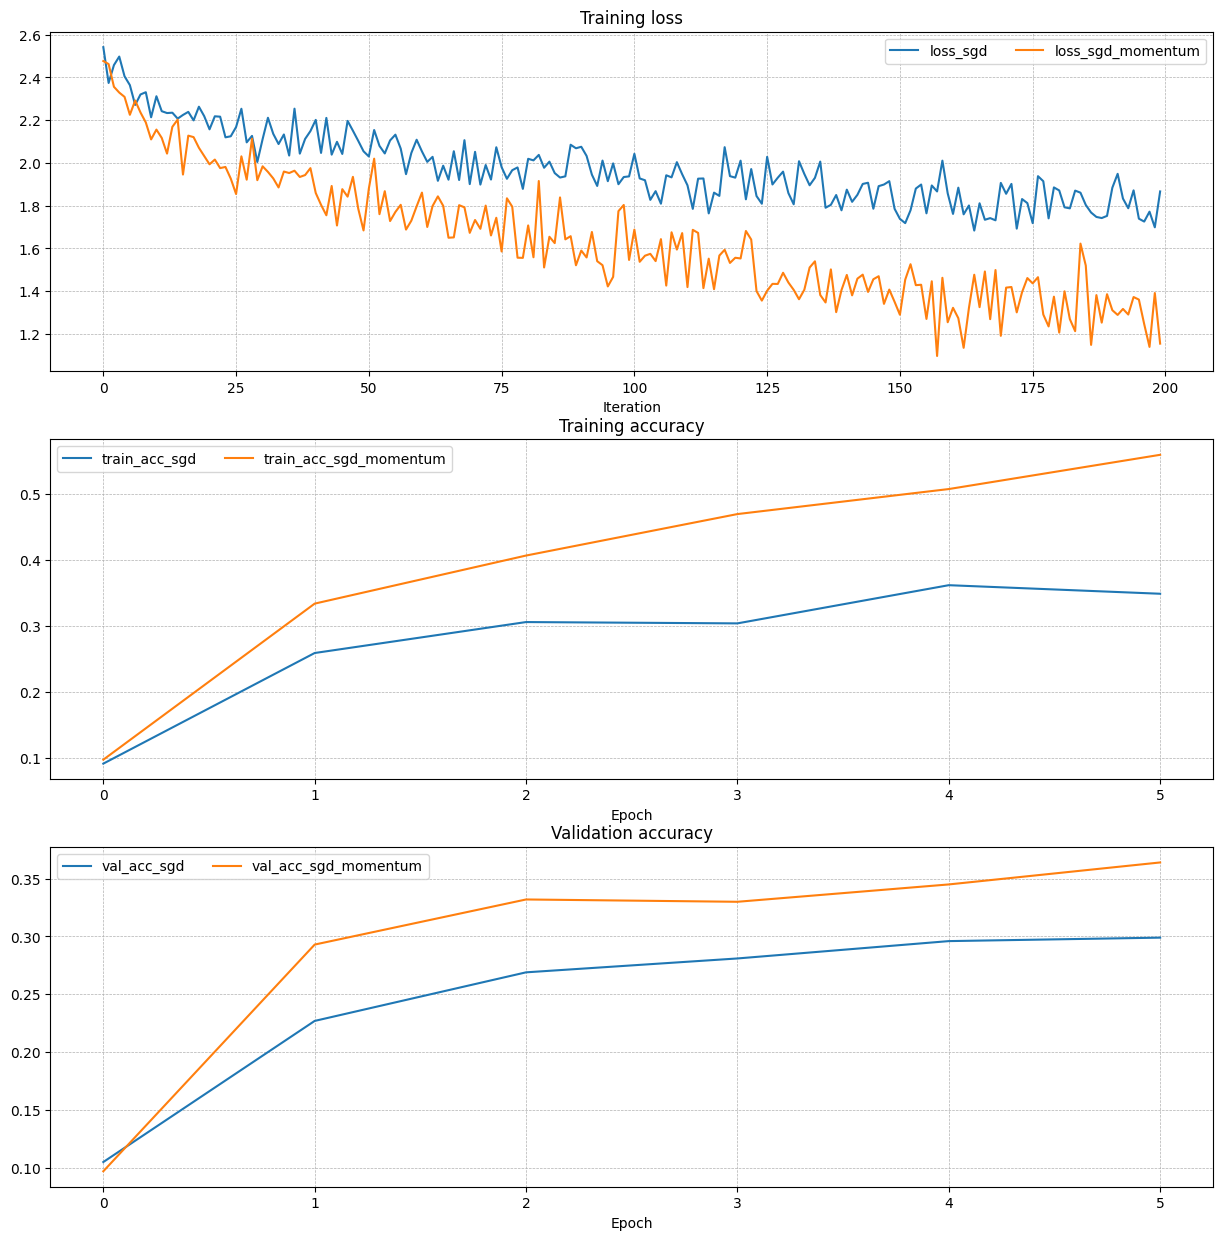

In [7]:
num_train = 4000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}

for update_rule in ['sgd', 'sgd_momentum']:
    print('Running with ', update_rule)
    model = FullyConnectedNet(
        [100, 100, 100, 100, 100],
        weight_scale=5e-2
    )

    solver = Solver(
        model,
        small_data,
        num_epochs=5,
        batch_size=100,
        update_rule=update_rule,
        optim_config={'learning_rate': 5e-3},
        verbose=True,
    )
    solvers[update_rule] = solver
    solver.train()

fig, axes = plt.subplots(3, 1, figsize=(15, 15))

axes[0].set_title('Training loss')
axes[0].set_xlabel('Iteration')
axes[1].set_title('Training accuracy')
axes[1].set_xlabel('Epoch')
axes[2].set_title('Validation accuracy')
axes[2].set_xlabel('Epoch')

for update_rule, solver in solvers.items():
    axes[0].plot(solver.loss_history, label=f"loss_{update_rule}")
    axes[1].plot(solver.train_acc_history, label=f"train_acc_{update_rule}")
    axes[2].plot(solver.val_acc_history, label=f"val_acc_{update_rule}")

for ax in axes:
    ax.legend(loc="best", ncol=4)
    ax.grid(linestyle='--', linewidth=0.5)

plt.show()

## RMSProp and Adam
RMSProp [1] and Adam [2] are update rules that set per-parameter learning rates by using a running average of the second moments of gradients.

In the file `cs231n/optim.py`, implement the RMSProp update rule in the `rmsprop` function and implement the Adam update rule in the `adam` function, and check your implementations using the tests below.

**NOTE:** Please implement the _complete_ Adam update rule (with the bias correction mechanism), not the first simplified version mentioned in the course notes.

[1] Tijmen Tieleman and Geoffrey Hinton. "Lecture 6.5-rmsprop: Divide the gradient by a running average of its recent magnitude." COURSERA: Neural Networks for Machine Learning 4 (2012).

[2] Diederik Kingma and Jimmy Ba, "Adam: A Method for Stochastic Optimization", ICLR 2015.

RMSProp和Adam
RMSProp[1]和Adam[2]是更新规则，通过使用梯度二阶矩的运行平均值来设置每个参数的学习率。
在文件cs231n/optim.py中，在RMSProp函数中实现RMSProp更新规则，在Adam函数中实现Adam更新规则，并使用以下测试检查您的实现。
注意：请实施完整的Adam更新规则（带有偏差校正机制），而不是课程笔记中提到的第一个简化版本。
[1] 蒂曼·蒂勒曼和杰弗里·辛顿。“讲座6.5-rmsprop：将梯度除以其最近幅度的运行平均值。”COURSERA：机器学习神经网络4（2012）。
[2] Diederik Kingma和Jimmy Ba，“Adam：随机优化方法”，ICLR 2015。

In [8]:
# Test RMSProp implementation
from cs231n.optim import rmsprop

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
cache = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'cache': cache}
next_w, _ = rmsprop(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.39223849, -0.34037513, -0.28849239, -0.23659121, -0.18467247],
  [-0.132737,   -0.08078555, -0.02881884,  0.02316247,  0.07515774],
  [ 0.12716641,  0.17918792,  0.23122175,  0.28326742,  0.33532447],
  [ 0.38739248,  0.43947102,  0.49155973,  0.54365823,  0.59576619]])
expected_cache = np.asarray([
  [ 0.5976,      0.6126277,   0.6277108,   0.64284931,  0.65804321],
  [ 0.67329252,  0.68859723,  0.70395734,  0.71937285,  0.73484377],
  [ 0.75037008,  0.7659518,   0.78158892,  0.79728144,  0.81302936],
  [ 0.82883269,  0.84469141,  0.86060554,  0.87657507,  0.8926    ]])

# You should see relative errors around e-7 or less
print('next_w error: ', rel_error(expected_next_w, next_w))
print('cache error: ', rel_error(expected_cache, config['cache']))

next_w error:  9.502645229894295e-08
cache error:  2.6477955807156126e-09


In [9]:
# Test RMSProp implementation
from cs231n.optim import rmsprop

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
cache = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'cache': cache}
next_w, _ = rmsprop(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.39223849, -0.34037513, -0.28849239, -0.23659121, -0.18467247],
  [-0.132737,   -0.08078555, -0.02881884,  0.02316247,  0.07515774],
  [ 0.12716641,  0.17918792,  0.23122175,  0.28326742,  0.33532447],
  [ 0.38739248,  0.43947102,  0.49155973,  0.54365823,  0.59576619]])
expected_cache = np.asarray([
  [ 0.5976,      0.6126277,   0.6277108,   0.64284931,  0.65804321],
  [ 0.67329252,  0.68859723,  0.70395734,  0.71937285,  0.73484377],
  [ 0.75037008,  0.7659518,   0.78158892,  0.79728144,  0.81302936],
  [ 0.82883269,  0.84469141,  0.86060554,  0.87657507,  0.8926    ]])

# You should see relative errors around e-7 or less
print('next_w error: ', rel_error(expected_next_w, next_w))
print('cache error: ', rel_error(expected_cache, config['cache']))

next_w error:  9.502645229894295e-08
cache error:  2.6477955807156126e-09


Once you have debugged your RMSProp and Adam implementations, run the following to train a pair of deep networks using these new update rules:

Running with  adam
(Iteration 1 / 200) loss: 2.538563
(Epoch 0 / 5) train acc: 0.125000; val_acc: 0.112000
(Iteration 11 / 200) loss: 2.047547
(Iteration 21 / 200) loss: 1.889385
(Iteration 31 / 200) loss: 1.819390
(Epoch 1 / 5) train acc: 0.335000; val_acc: 0.307000
(Iteration 41 / 200) loss: 1.804653
(Iteration 51 / 200) loss: 1.708107
(Iteration 61 / 200) loss: 1.676728
(Iteration 71 / 200) loss: 1.506074
(Epoch 2 / 5) train acc: 0.411000; val_acc: 0.340000
(Iteration 81 / 200) loss: 1.828438
(Iteration 91 / 200) loss: 1.544976
(Iteration 101 / 200) loss: 1.437814
(Iteration 111 / 200) loss: 1.483974
(Epoch 3 / 5) train acc: 0.452000; val_acc: 0.359000
(Iteration 121 / 200) loss: 1.487425
(Iteration 131 / 200) loss: 1.468363
(Iteration 141 / 200) loss: 1.373956
(Iteration 151 / 200) loss: 1.420192
(Epoch 4 / 5) train acc: 0.542000; val_acc: 0.371000
(Iteration 161 / 200) loss: 1.385163
(Iteration 171 / 200) loss: 1.151676
(Iteration 181 / 200) loss: 1.455963
(Iteration 191 / 200) lo

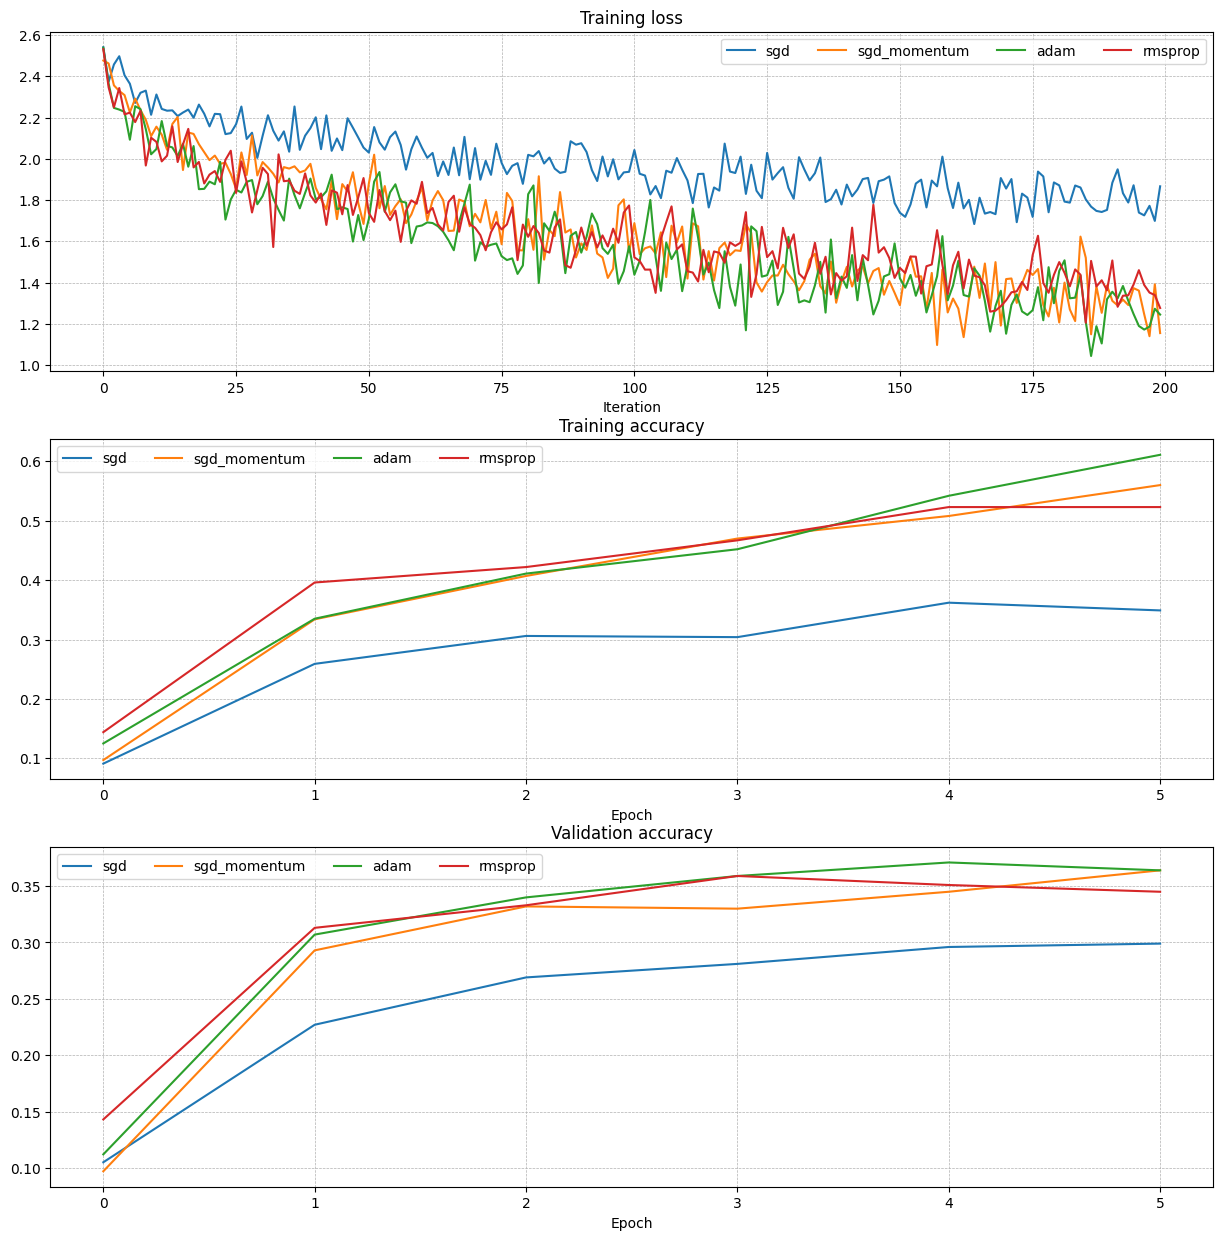

In [10]:
learning_rates = {'rmsprop': 1e-4, 'adam': 1e-3}
for update_rule in ['adam', 'rmsprop']:
    print('Running with ', update_rule)
    model = FullyConnectedNet(
        [100, 100, 100, 100, 100],
        weight_scale=5e-2
    )
    solver = Solver(
        model,
        small_data,
        num_epochs=5,
        batch_size=100,
        update_rule=update_rule,
        optim_config={'learning_rate': learning_rates[update_rule]},
        verbose=True
    )
    solvers[update_rule] = solver
    solver.train()
    print()

fig, axes = plt.subplots(3, 1, figsize=(15, 15))

axes[0].set_title('Training loss')
axes[0].set_xlabel('Iteration')
axes[1].set_title('Training accuracy')
axes[1].set_xlabel('Epoch')
axes[2].set_title('Validation accuracy')
axes[2].set_xlabel('Epoch')

for update_rule, solver in solvers.items():
    axes[0].plot(solver.loss_history, label=f"{update_rule}")
    axes[1].plot(solver.train_acc_history, label=f"{update_rule}")
    axes[2].plot(solver.val_acc_history, label=f"{update_rule}")

for ax in axes:
    ax.legend(loc='best', ncol=4)
    ax.grid(linestyle='--', linewidth=0.5)

plt.show()

## Inline Question 2:

AdaGrad, like Adam, is a per-parameter optimization method that uses the following update rule:

```
cache += dw**2
w += - learning_rate * dw / (np.sqrt(cache) + eps)
```

John notices that when he was training a network with AdaGrad that the updates became very small, and that his network was learning slowly. Using your knowledge of the AdaGrad update rule, why do you think the updates would become very small? Would Adam have the same issue?


## Answer:
[FILL THIS IN]

##内联问题2：

AdaGrad和Adam一样，是一种按参数优化的方法，使用以下更新规则：

```
缓存+=dw**2
w+=-learning_rate*dw/（np.sqrt（缓存）+eps）
```

John注意到，当他使用AdaGrad训练网络时，更新变得非常小，他的网络学习速度很慢。根据您对AdaGrad更新规则的了解，为什么您认为更新会变得非常小？亚当会有同样的问题吗？


##答案：

[填写此项]
在AdaGrad中，更新变得非常小的原因在于cache累积了梯度的平方。公式中的cache += dw**2随着训练的进行，会逐渐累积越来越大的值。而在后续的更新公式中，权重更新量w被np.sqrt(cache)所除。当cache变得很大时，除数变大，导致权重更新变得非常小，从而影响网络的学习速度。也就是说，AdaGrad在处理长时间训练时，更新步长会逐渐变小，最终导致模型学习变得非常缓慢。

Adam则不会遇到完全相同的问题。虽然Adam也使用了梯度平方的累积（类似AdaGrad的cache），但它通过引入移动平均和偏差校正（分别是m和v）来防止累积的过度增长。因此，Adam能动态调整学习率，避免像AdaGrad那样因累积效应导致更新过小的问题。

因此，虽然两者都基于梯度的平方累积，但Adam通过设计上的改进，能够更好地控制更新的大小，防止像AdaGrad那样学习过慢的情况。

# Train a Good Model!
Train the best fully connected model that you can on CIFAR-10, storing your best model in the `best_model` variable. We require you to get at least 50% accuracy on the validation set using a fully connected network.

If you are careful it should be possible to get accuracies above 55%, but we don't require it for this part and won't assign extra credit for doing so. Later in the assignment we will ask you to train the best convolutional network that you can on CIFAR-10, and we would prefer that you spend your effort working on convolutional networks rather than fully connected networks.

**Note:** You might find it useful to complete the `BatchNormalization.ipynb` and `Dropout.ipynb` notebooks before completing this part, since those techniques can help you train powerful models.

# 培养一个好模型！
在CIFAR-10上训练最好的全连接模型，将最好的模型存储在“best_model”变量中。我们要求您使用完全连接的网络在验证集上获得至少50%的准确性。
如果你小心的话，应该有可能获得55%以上的准确率，但我们不要求这一部分，也不会为此分配额外的学分。在作业的后面，我们将要求你在CIFAR-10上训练出最好的卷积网络，我们希望你把精力花在卷积网络上，而不是完全连接的网络上。
**注意：** 在完成本部分之前，您可能会发现完成`BatchNormalize.ipynb`和`Dropout.ipynb'笔记本很有用，因为这些技术可以帮助您训练强大的模型。

In [11]:
best_model = None

################################################################################
# TODO: Train the best FullyConnectedNet that you can on CIFAR-10. You might   #
# find batch/layer normalization and dropout useful. Store your best model in  #
# the best_model variable.                                                     #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

learning_rate_List=[2e-4]
regList=[1e-3,1e-2]
bestValAcc=0
findRes={}
for tlr in learning_rate_List:
    for treg in regList:
        print(tlr,treg)
        model = FullyConnectedNet(
            [100, 100, 100, 100, 100],
            weight_scale=5e-2,
            input_dim=3 * 32 * 32,
            num_classes=10,
            reg=treg
        )
        solver = Solver(
        model,
        data,
        num_epochs=5,
        batch_size=100,
        update_rule="adam",
        optim_config={'learning_rate': tlr},
        verbose=True,
        print_every=100,
        )
        solver.train()
        tvalAcc=solver.loss_history[-1]
        if tvalAcc>bestValAcc:
            bestValAcc=tvalAcc
            best_model=model
        findRes[(tlr,treg)]=tvalAcc
for temp in findRes.keys():
    print(temp,findRes[temp])
# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

0.0002 0.001
(Iteration 1 / 2450) loss: 2.975330
(Epoch 0 / 5) train acc: 0.091000; val_acc: 0.095000
(Iteration 101 / 2450) loss: 2.276530
(Iteration 201 / 2450) loss: 2.279074
(Iteration 301 / 2450) loss: 2.026925
(Iteration 401 / 2450) loss: 2.067291
(Epoch 1 / 5) train acc: 0.430000; val_acc: 0.421000
(Iteration 501 / 2450) loss: 1.903658
(Iteration 601 / 2450) loss: 1.899228
(Iteration 701 / 2450) loss: 2.109615
(Iteration 801 / 2450) loss: 2.074069
(Iteration 901 / 2450) loss: 1.771745
(Epoch 2 / 5) train acc: 0.471000; val_acc: 0.469000
(Iteration 1001 / 2450) loss: 1.864125
(Iteration 1101 / 2450) loss: 1.759886
(Iteration 1201 / 2450) loss: 1.784819
(Iteration 1301 / 2450) loss: 1.862980
(Iteration 1401 / 2450) loss: 1.713143
(Epoch 3 / 5) train acc: 0.502000; val_acc: 0.476000
(Iteration 1501 / 2450) loss: 1.579968
(Iteration 1601 / 2450) loss: 1.686081
(Iteration 1701 / 2450) loss: 1.745287
(Iteration 1801 / 2450) loss: 1.608461
(Iteration 1901 / 2450) loss: 1.845588
(Epoch 

# Test Your Model!
Run your best model on the validation and test sets. You should achieve at least 50% accuracy on the validation set.

In [12]:
y_test_pred = np.argmax(best_model.loss(data['X_test']), axis=1)
y_val_pred = np.argmax(best_model.loss(data['X_val']), axis=1)
print('Validation set accuracy: ', (y_val_pred == data['y_val']).mean())
print('Test set accuracy: ', (y_test_pred == data['y_test']).mean())

Validation set accuracy:  0.513
Test set accuracy:  0.495
